# Modelo de classificação - IMC

- Pacotes utilizados

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import sklearn.preprocessing as prep
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from scipy.stats import shapiro, f_oneway
from statsmodels.stats.multicomp import MultiComparison
from sklearn.metrics import accuracy_score, classification_report
from yellowbrick.classifier import ConfusionMatrix

- Exploração e tratamento de dados

In [2]:
base = pd.read_csv(r'\Facul\analise_dados\archive\ObesityDataSet.csv')

In [3]:
base.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
base.tail()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III
2110,Female,23.664709,1.738836,133.472641,yes,yes,3.0,3.0,Sometimes,no,2.863513,no,1.026452,0.714137,Sometimes,Public_Transportation,Obesity_Type_III


In [169]:
base.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


> Considerando que, as variáveis numéricas acima não estão em escalas muito distantes, não será feito o escalonamento/normalização dos valores. Mas, será necessário realizar a codificação das variáveis binárias, ordinais e nominais.

In [5]:
# encoding das variáveis:
base['CAEC'] = base['CAEC'].map({'Always': 3, 'Frequently': 2, 'Sometimes': 1, 'no': 0}) 
base['CALC'] = base['CALC'].map({'Always': 3, 'Frequently': 2, 'Sometimes': 1, 'no': 0})
base['FAVC'] = base['FAVC'].map({'yes': 1, 'no': 0})
base['FCVC'] = base['FCVC'].map(lambda y: int(round(y)))
base['FAF'] = base['FAF'].map(lambda y: int(round(y)))
base['Female'] = base['Gender'].map({'Female': 1, 'Male': 0})
base['obesity_history'] = base['family_history_with_overweight'].map({'yes': 1, 'no': 0})
base['smoker'] = base['SMOKE'].map({'yes': 1, 'no': 0})
base['SCC'] = base['SCC'].map({'yes': 1, 'no': 0})

> A princípio, busca-se entender um pouco mais sobre a base, como os dados estão distribuídos e possíveis relações entre variáveis preditoras e a variável resposta (NObeyesdad).

In [6]:
# Categorias: IMC
np.unique(base['NObeyesdad'], return_counts=True)

(array(['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I',
        'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I',
        'Overweight_Level_II'], dtype=object),
 array([272, 287, 351, 297, 324, 290, 290], dtype=int64))

> Observa-se que, a base tem um bom equilíbrio no que se refere à quantidade de casos por categoria de IMC. Isso é visto como algo vantajoso para fins de generalização e previsão para todas as classes, pois pode resultar em um modelo mais justo e preciso, especialmente em tarefas de classificação com classes desbalanceadas.

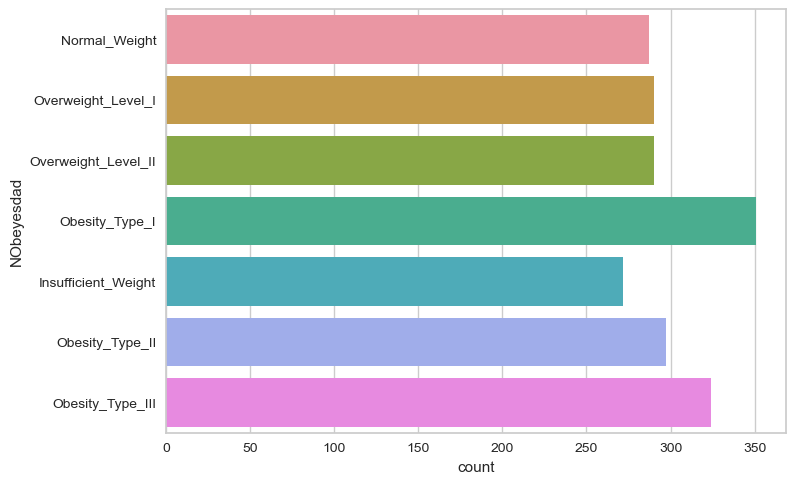

In [7]:
# Observações por categoria de IMC
sns.countplot(y = base['NObeyesdad']);

> Quanto à distribuição do peso, vê-se que:
- Apenas 3 categorias possuem _outliers_ (valores extremos que excedem o intervalo esperado para a categoria);
- O intervalo de dispersão das categorias são assimétricas (forma da caixa), o que indica uma distribuição não uniforme dos pesos, e consequentemente, a hipótese inicial de que a presença de outros fatores afetam o IMC. 

In [26]:
# Distribuição do peso por categoria
px.box(base, x='NObeyesdad', y='Weight', 
       category_orders={'NObeyesdad': ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 
                                      'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 
                                     'Obesity_Type_III']})

> Quanto ao _range_ de idade da base, vê-se:
- A idade média dos indivíduos é de aproximadamente 24,31 anos;
- A idade mínima é de 14 anos e a idade máxima é de 61 anos;
- 25% dos indivíduos têm 19,95 anos ou menos;
- 50% dos indivíduos têm 22,78 anos ou menos;
- 25% dos indivíduos têm 26 anos ou mais;
- A distribuição dos dados é assimétrica à direita, ou seja, a base possui, em sua maioria, dados de indivíduos mais jovens.

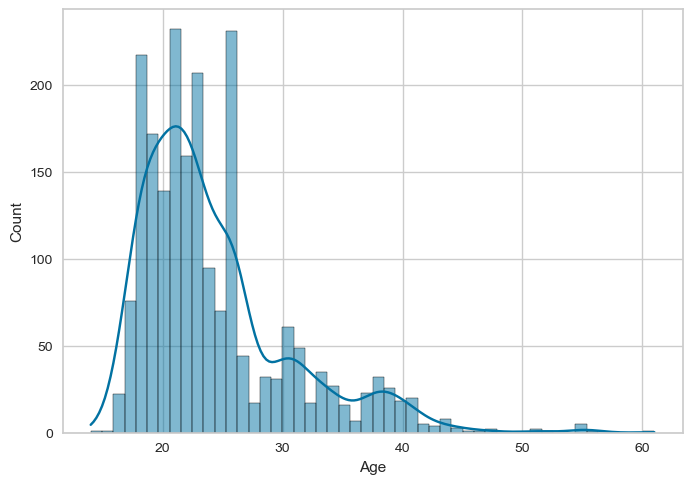

In [9]:
# Distribuição etária
sns.histplot(data=base, x="Age", bins=50, kde=True);

| IMC | Male | Female | Total |
| :------- | ------ | -------- | ------------ |
| Insufficient Weight | 36,4% | 63,6% | 272 |
| Normal Weight | 50,8% | 49,1% | 287 |
| Overweight type I | 50% | 50% | 290 |
| Overweight type II | 64,5% | 35,5% | 290 |
| Obesity type I | 55,5% | 44,4% | 351 |
| Obesity type II | 99,3% | 0,6% | 297 |
| Obesity type III | 0,3% | 99,7% | 324 |
> Dos 2.111 indivíduos constantes na base, 49,4% são do sexo feminino, enquanto 50,6% são do sexo masculino. Essa disparidade está concentrada nas categorias de Obesidade tipo I e II.

In [10]:
# Distribuição por gênero
bd = base.groupby(['NObeyesdad', 'Gender']).agg(**{'imc': ('NObeyesdad', 'count')}) 
bd.reset_index(inplace=True)
px.bar(bd, x="NObeyesdad", y='imc', color="Gender", text_auto=True)

> A amostra, em sua maioria, consome alimentos de alto teor calórico, e por isso, é possível que a relação entre essa variável e a variável resposta não seja inteiramente mapeada pelo modelo.

In [11]:
# Distribuição de IMC vs consumo de alimentos com alto teor calórico
bd = base.groupby(['NObeyesdad', 'FAVC']).agg(**{'imc': ('NObeyesdad', 'count')}) 
bd.reset_index(inplace=True)
px.bar(bd, x='NObeyesdad', y='imc', color='FAVC', text_auto=True)

> Visto que, a vasta maioria dos indivíduos da amostra são não-fumantes, é possível que o impacto de ser fumante não seja devidamente incorporado ao modelo.

In [12]:
# Distribuição de IMC - fumantes e não-fumantes
bd = base.groupby(['NObeyesdad', 'smoker']).agg(**{'imc': ('NObeyesdad', 'count')}) 
bd.reset_index(inplace=True)
px.bar(bd, x='NObeyesdad', y='imc', color='smoker', text_auto=True)

> A visão seguinte confirma que, além do peso (conforme visto no _boxplot_), a altura também influencia quase que decisivamente na classificação do IMC do indivíduo. Porém, observando a olho nu, há casos de categorias diferentes que ocupam praticamente a mesma área, e são esses os casos que espera-se que sejam explicados pelo modelo que será criado.   

In [13]:
# IMC - Peso vs Altura
px.scatter(base, y="Weight", x="Height", color="NObeyesdad")

> Com relação à prática da atividade física, para os casos de obesidade tipo II e III, vê-se que a frequência varia entre 0 (nunca) e 2 (frequentemente), com ênfase na ausência de prática de exercício. 
Já para os casos de peso sobrepeso e obesidade I, a prática de exercícios tem concentração maior nas frequências entre 1 (às vezes) e 3 (sempre). 
Esse padrão gera a hipótese de que praticantes de exercícios físicos podem possuir um IMC mais alto (possivelmente devido ao ganho de massa magra), e portanto, nem todo IMC alto é indicativo de risco à saude, assim, faz sentido que fatores além da altura e peso do indivíduo estejam envolvidos na determinação do IMC.

In [14]:
# IMC vs Frequência de prática de atividade física
bd = base.groupby(['NObeyesdad', 'FAF']).agg(**{'imc': ('NObeyesdad', 'count')}) 
bd.reset_index(inplace=True)
px.bar(bd, y="NObeyesdad", x="imc", color='FAF')

> O gráfico abaixo tem como objetivo possibilitar a navegação entre as diferentes categorias de IMC, dinamizando a observação do comportamento amostral por: IMC, gênero, idade, consumo de água, tempo gasto com dispositivos eletrônicos e meio de transporte mais usado.

In [15]:
px.treemap(base, path=['NObeyesdad', 'Gender', 'Age', 'CH2O', 'TUE', 'MTRANS'])

In [57]:
# Verificação da existência de dados faltantes
base.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
Female                            0
obesity_history                   0
smoker                            0
dtype: int64

In [16]:
# Divisão entre previsores e classe
# Para implementar os modelos, a base tem que ser do tipo ndarray

X = base[['Female', 'Age', 'Height', 'Weight', 'obesity_history', 'FAVC', 'FCVC', 'NCP', 'CAEC', 
          'smoker', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']].values
type(X)

numpy.ndarray

In [17]:
y = np.ravel(base[['NObeyesdad']].values)
type(y)

numpy.ndarray

In [18]:
# Codificação de categorias - atribui um valor a cada classe de cada atributo
# Usado apenas na variável MTRANS. Por ser uma variável nominal,precisamos criar uma coluna binária para cada classe

label_encoder = prep.LabelEncoder()

In [19]:
X[:,15]

array(['Public_Transportation', 'Public_Transportation',
       'Public_Transportation', ..., 'Public_Transportation',
       'Public_Transportation', 'Public_Transportation'], dtype=object)

In [20]:
# Codificação com OneHotEncoder: cria uma coluna dummy para cada classe de cada atributo
onehotencoder = ColumnTransformer(transformers=[('OneHot', prep.OneHotEncoder(), [15])], remainder='passthrough')
X = onehotencoder.fit_transform(X)

In [21]:
# Colunas da base X
list(onehotencoder.get_feature_names_out())

['OneHot__x15_Automobile',
 'OneHot__x15_Bike',
 'OneHot__x15_Motorbike',
 'OneHot__x15_Public_Transportation',
 'OneHot__x15_Walking',
 'remainder__x0',
 'remainder__x1',
 'remainder__x2',
 'remainder__x3',
 'remainder__x4',
 'remainder__x5',
 'remainder__x6',
 'remainder__x7',
 'remainder__x8',
 'remainder__x9',
 'remainder__x10',
 'remainder__x11',
 'remainder__x12',
 'remainder__x13',
 'remainder__x14']

> A divisão da base entre teste e treino terá a proporção 30/70, ou seja, 70% dos dados foram destinados para o treinamento do modelo, e 30% para os testes e validações do modelo. 

In [22]:
# Divisão das bases em treinamento e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [23]:
X_teste.shape, y_teste.shape

((634, 20), (634,))

In [24]:
# Save das bases tratadas
with open(r'bd_obesidade.pkl', mode = 'wb') as f:
  pickle.dump([X_treino, y_treino, X_teste, y_teste], f)

## Treinamento dos modelos de classificação

- Naive Bayes 

In [68]:
# parâmetros que serão testados em diferentes combinações, através do GridSearch
parametros = {'var_smoothing': [1e-9, 1e-5, 1e-1], 'priors': [None]} 

grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=parametros)
grid_search.fit(X, y)
melhores_parametros_naive = grid_search.best_params_

# Melhor conjunto de parâmetros (considerando o conceito de minimização do gradiente)
melhores_parametros_naive

{'priors': None, 'var_smoothing': 1e-05}

In [69]:
grid_search.classes_ # para ver as classes em que o objeto pode ser classificado

array(['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I',
       'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I',
       'Overweight_Level_II'], dtype='<U19')

In [70]:
grid_search.best_estimator_.class_prior_ # probabilidades a priori de cada classe, estimadas a partir dos dados de treinamento

array([0.12884889, 0.13595452, 0.16627191, 0.14069162, 0.15348176,
       0.13737565, 0.13737565])

> **R²**: indica a capacidade do modelo de explicar os dados de treinamento. 
Ex: Segundo o _output_ abaixo, 60,16% da variação dos dados podem ser explicadas pelo modelo estimado.

In [71]:
melhor_resultado_naive = grid_search.best_score_ # R^2
melhor_resultado_naive

0.6016559667462158

- Árvore de decisão

In [72]:
parametros = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'min_samples_split': [2, 5, 10, 15], # 2 é default
              'min_samples_leaf': [1, 5, 10, 15]} # 1 é default

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=parametros)
grid_search.fit(X, y)
melhores_parametros_tree = grid_search.best_params_

# Melhor conjunto de parâmetros (considerando o conceito de minimização do gradiente)
melhores_parametros_tree

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'splitter': 'best'}

In [73]:
melhor_resultado_tree = grid_search.best_score_ # R^2
melhor_resultado_tree

0.934188206558883

- Random Forest

In [74]:
parametros = {'criterion': ['gini', 'entropy'],
              'n_estimators': [10, 40, 100, 130, 150, 200],
              'min_samples_split': [2, 5, 10, 15],
              'min_samples_leaf': [1, 5, 10, 15]}

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parametros)
grid_search.fit(X, y)
melhores_parametros_forest = grid_search.best_params_

# Melhores parâmetros
melhores_parametros_forest

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 130}

In [75]:
# R^2
melhor_resultado_forest = grid_search.best_score_
melhor_resultado_forest

0.9385017870547768

- KNN

In [76]:
parametros = {'n_neighbors': [3, 5, 10, 20, 25, 30],
              'p': [1, 2]}
grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parametros)
grid_search.fit(X, y)
melhores_parametros_knn = grid_search.best_params_

# Melhores parâmetros
melhores_parametros_knn

{'n_neighbors': 3, 'p': 1}

In [77]:
# R^2
melhor_resultado_knn = grid_search.best_score_
melhor_resultado_knn

0.9171131502582547

- Regressão Logística

In [78]:
parametros = {'tol': [0.0001, 0.00001, 0.000001, 0.0000000000001],
              'C': [1.0, 1.35, 1.5, 2.0],
              'solver': ['lbfgs', 'sag', 'saga']}
grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=parametros)
grid_search.fit(X, y)
melhores_parametros_reglog = grid_search.best_params_

# Melhores parâmetros
melhores_parametros_reglog

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

{'C': 1.0, 'solver': 'lbfgs', 'tol': 0.0001}

In [79]:
# R^2
melhor_resultado_reglog = grid_search.best_score_
melhor_resultado_reglog

0.6689153305771234

- SVM

In [80]:
parametros = {'tol': [0.001, 0.0001, 0.00001],
              'C': [1.0, 1.35, 1.5, 2.0, 2.35],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
grid_search = GridSearchCV(estimator=SVC(), param_grid=parametros)
grid_search.fit(X, y)
melhores_parametros_svm = grid_search.best_params_

# Melhores parâmetros
melhores_parametros_svm

{'C': 2.35, 'kernel': 'linear', 'tol': 0.001}

In [81]:
# R^2
melhor_resultado_svm = grid_search.best_score_
melhor_resultado_svm

0.8991619329322262

- Redes neurais

In [82]:
parametros = {'activation': ['relu', 'logistic', 'tanh', 'identity'],
              'solver': ['lbfgs', 'adam', 'sgd'],
              'batch_size': [10, 15, 20, 30, 35], 'max_iter': [1000]}

grid_search = GridSearchCV(estimator=MLPClassifier(), param_grid=parametros)
grid_search.fit(X, y)
melhores_parametros_rn = grid_search.best_params_

# Melhores parâmetros
melhores_parametros_rn

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modul

{'activation': 'logistic',
 'batch_size': 20,
 'max_iter': 1000,
 'solver': 'adam'}

In [83]:
# R^2
melhor_resultado_rn = grid_search.best_score_
melhor_resultado_rn

0.8968180341277044

## Validação cruzada

In [86]:
resultados_bayes = []
resultados_arvore = []
resultados_random_forest = []
resultados_knn = []
resultados_logistica = []
resultados_svm = []
resultados_rede_neural = []
m = 30

for i in range(m):
  print(i)
  kfold = KFold(n_splits=10, shuffle=True, random_state=i) # 10 é o n de folds comumente usado, com o random_s sempre diferente, toda estimativa é diferente
  
  naive_bayes = GaussianNB(priors=melhores_parametros_naive['priors'], var_smoothing=melhores_parametros_naive['var_smoothing'])
  scores = cross_val_score(naive_bayes, X, y, cv=kfold)
  resultados_bayes.append(scores.mean())

  arvore = DecisionTreeClassifier(criterion=melhores_parametros_tree['criterion'], min_samples_leaf=melhores_parametros_tree['min_samples_leaf'], min_samples_split=melhores_parametros_tree['min_samples_split'], splitter=melhores_parametros_tree['splitter'])
  scores = cross_val_score(arvore, X, y, cv=kfold)
  resultados_arvore.append(scores.mean())

  random_forest = RandomForestClassifier(criterion=melhores_parametros_forest['criterion'], min_samples_leaf=melhores_parametros_forest['min_samples_leaf'], min_samples_split=melhores_parametros_forest['min_samples_split'], n_estimators=melhores_parametros_forest['n_estimators'])
  scores = cross_val_score(random_forest, X, y, cv=kfold)
  resultados_random_forest.append(scores.mean())

  knn = KNeighborsClassifier(n_neighbors=melhores_parametros_knn['n_neighbors'], p=melhores_parametros_knn['p'])
  scores = cross_val_score(knn, X, y, cv=kfold)
  resultados_knn.append(scores.mean())

  logistica = LogisticRegression(C=melhores_parametros_reglog['C'], solver=melhores_parametros_reglog['solver'], tol=melhores_parametros_reglog['tol'])
  scores = cross_val_score(logistica, X, y, cv=kfold)
  resultados_logistica.append(scores.mean())

  svm = SVC(kernel=melhores_parametros_svm['kernel'], C=melhores_parametros_svm['C'], tol=melhores_parametros_svm['tol'])
  scores = cross_val_score(svm, X, y, cv=kfold)
  resultados_svm.append(scores.mean())
  
  rede_neural = MLPClassifier(activation=melhores_parametros_rn['activation'], batch_size=melhores_parametros_rn['batch_size'], max_iter=melhores_parametros_rn['max_iter'], solver=melhores_parametros_rn['solver'])
  scores = cross_val_score(rede_neural, X, y, cv=kfold)
  resultados_rede_neural.append(scores.mean())

resultados = pd.DataFrame({'Naive Bayes': resultados_bayes, 'Arvore': resultados_arvore, 'Random forest': resultados_random_forest,
                           'KNN': resultados_knn, 'Logistica': resultados_logistica,
                           'SVM': resultados_svm, 'Rede neural': resultados_rede_neural})


0


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

1


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

2


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

3


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

4


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

5


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

6


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

7


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

8


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

9


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

10


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

11


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

12


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

13


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

14


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

15


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

16


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

17


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

18


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

19


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

20


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

21


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

22


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

23


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

24


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

25


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

26


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

27


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

28


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

29


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\anaconda3\Lib\site-packages

In [87]:
resultados

,Naive Bayes,Arvore,Random forest,KNN,Logistica,SVM,Rede neural
0,0.615334,0.954525,0.954999,0.925154,0.671738,0.911410,0.914258
1,0.615845,0.955461,0.957844,0.925615,0.676927,0.917578,0.919476
2,0.614842,0.953096,0.960207,0.924674,0.673601,0.911880,0.917091
3,0.616771,0.949314,0.953103,0.917562,0.665550,0.912828,0.913773
4,0.616764,0.955473,0.952638,0.926091,0.667927,0.914728,0.913780
5,0.616791,0.955958,0.951692,0.919961,0.676963,0.914741,0.915231
6,0.615816,0.955014,0.950735,0.928487,0.666970,0.910945,0.906208
7,0.614406,0.957353,0.957366,0.920893,0.675040,0.916145,0.911426
8,0.614401,0.955479,0.953098,0.925143,0.674542,0.915669,0.919948
9,0.612997,0.952151,0.956883,0.926102,0.676442,0.912383,0.910462


In [88]:
resultados.describe()

,Naive Bayes,Arvore,Random forest,KNN,Logistica,SVM,Rede neural
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.615271,0.953261,0.954966,0.924001,0.670947,0.915126,0.914732
std,0.001637,0.003191,0.002423,0.002948,0.004654,0.002373,0.004015
min,0.610587,0.946477,0.950724,0.917562,0.658944,0.910945,0.906208
25%,0.614404,0.951208,0.953103,0.922307,0.668057,0.913428,0.911424
50%,0.615820,0.953334,0.954520,0.924437,0.671716,0.915205,0.914501
75%,0.616645,0.955470,0.956897,0.926091,0.674306,0.917109,0.917930
max,0.617719,0.961627,0.960207,0.929880,0.678344,0.918524,0.920891


In [89]:
resultados.var()

Naive Bayes      0.000003
Arvore           0.000010
Random forest    0.000006
KNN              0.000009
Logistica        0.000022
SVM              0.000006
Rede neural      0.000016
dtype: float64

In [90]:
(resultados.std() / resultados.mean()) * 100 # coef de variacao

Naive Bayes      0.266029
Arvore           0.334774
Random forest    0.253720
KNN              0.319014
Logistica        0.693581
SVM              0.259324
Rede neural      0.438960
dtype: float64

- Teste de normalidade de Shapiro

**alpha**: probabilidade de erro ao rejeitar a hipótese nula (H0) de um teste de hipóteses. Os valores comumente empregados são 1%, 5% e/ou 10%.

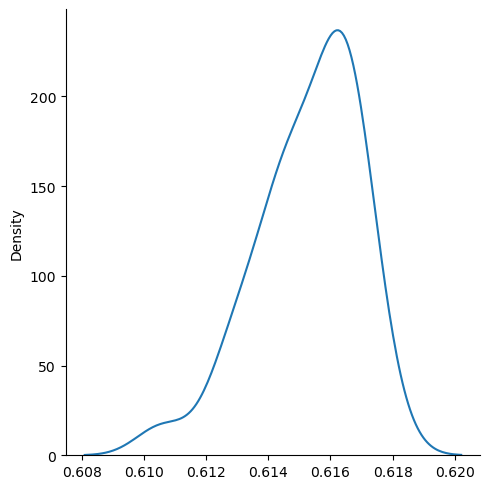

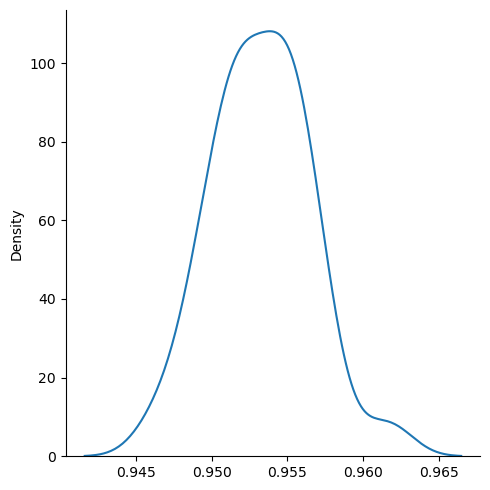

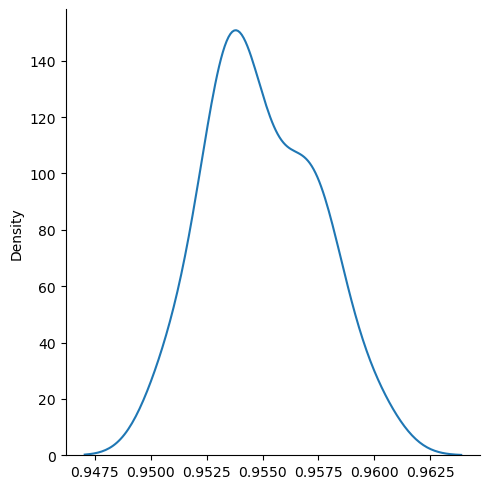

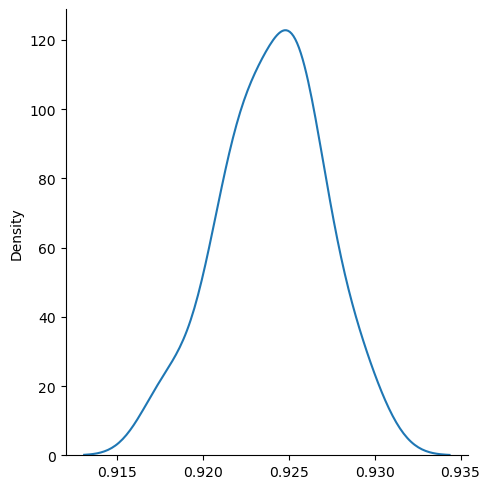

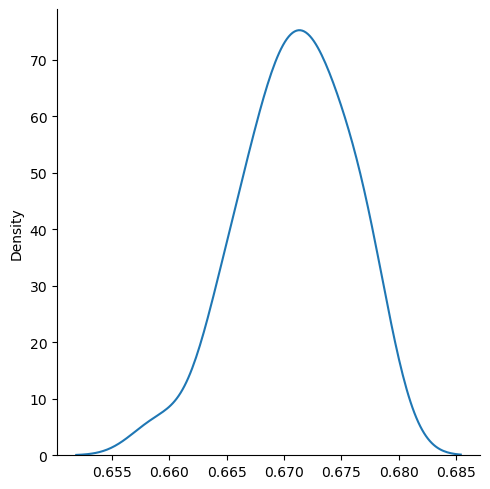

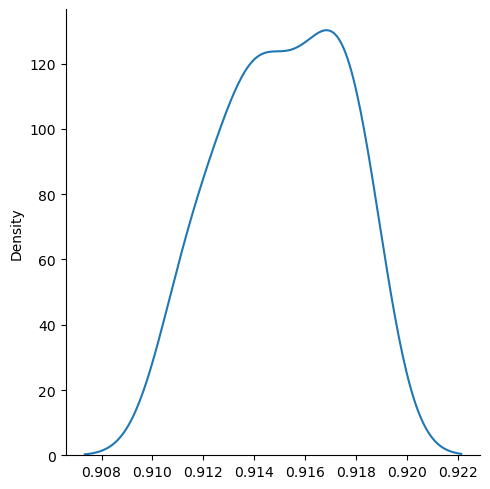

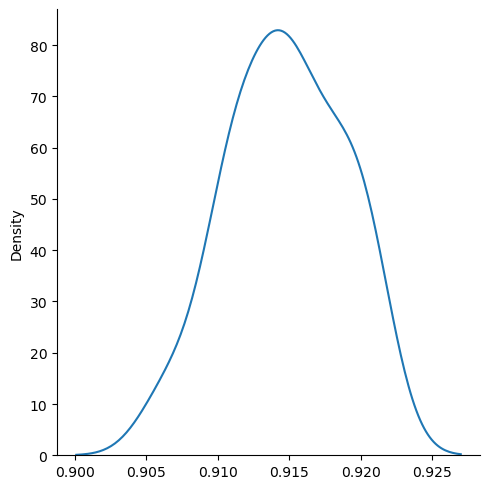

In [91]:
alpha = 0.05

shapiro(resultados_bayes), shapiro(resultados_arvore), shapiro(resultados_random_forest), shapiro(resultados_knn), shapiro(resultados_logistica), shapiro(resultados_svm), shapiro(resultados_rede_neural)

sns.displot(resultados_bayes, kind='kde')
sns.displot(resultados_arvore, kind='kde')
sns.displot(resultados_random_forest, kind='kde')
sns.displot(resultados_knn, kind='kde')
sns.displot(resultados_logistica, kind='kde')
sns.displot(resultados_svm, kind='kde')
sns.displot(resultados_rede_neural, kind='kde')

 - Teste de hipótese com ANOVA e Tukey

> A **H0** da ANOVA afirma que não há diferença significativa entre as médias dos grupos, enquanto a **H1** afirma que há pelo menos uma diferença significativa entre as médias.

In [94]:
_, p = f_oneway(resultados_bayes, resultados_arvore, resultados_random_forest, resultados_knn, resultados_logistica, resultados_svm, resultados_rede_neural)
p 

0.0

In [95]:
if p <= alpha:
  print('Hipótese nula rejeitada. Há um modelo com desempenho superior.')
else:
  print('Hipótese alternativa rejeitada. Resultados são iguais')

Hipótese nula rejeitada. Há um modelo com desempenho superior.


In [96]:
resultados_algoritmos = {'accuracy': np.concatenate([resultados_bayes, resultados_arvore, resultados_random_forest, resultados_knn, resultados_logistica, resultados_svm, resultados_rede_neural]),
                         'algoritmo': ['naive_bayes' for i in range(m)] + ['arvore' for i in range(m)] +
                         ['random_forest' for i in range(m)] + ['knn' for i in range(m)] + ['logistica' for i in range(m)]
                         + ['svm' for i in range(m)] + ['rede_neural' for i in range(m)]}

resultados_df = pd.DataFrame(resultados_algoritmos)
resultados_df

,accuracy,algoritmo
0,0.615334,naive_bayes
1,0.615845,naive_bayes
2,0.614842,naive_bayes
3,0.616771,naive_bayes
4,0.616764,naive_bayes
...,...,...
205,0.915193,rede_neural
206,0.914267,rede_neural
207,0.910480,rede_neural
208,0.920406,rede_neural


> Após atestar (com a ANOVA) que existe um modelo que se diferencia dos demais, utiliza-se o teste de Tukey para identificar quais grupos têm médias significativamente diferentes entre si. O teste usa a acurácia de cada modelo criado nas n iterações da validação cruzada.

Conteúdo da tabela:

**group1 e group2:** Os grupos que estão sendo comparados.

**meandiff:** A diferença média entre os grupos. Este é o valor pelo qual a média de group1 é maior ou menor do que a média de group2.

**lower e upper:** O intervalo de confiança de 95% para a diferença média. Isso significa que há uma probabilidade de 95% de que a diferença real entre as médias esteja dentro deste intervalo.

**reject:** Indica se a hipótese nula de que não há diferença significativa entre as médias pode ser rejeitada. Se reject for True, significa que a diferença entre as médias é estatisticamente significativa.

**p-adj:** O valor p ajustado para a comparação. Isso leva em consideração o número de comparações realizadas e é usado para determinar se a diferença entre as médias é estatisticamente significativa.

In [101]:
compara_algoritmos = MultiComparison(resultados_df['accuracy'], resultados_df['algoritmo'])
teste_estatistico = compara_algoritmos.tukeyhsd()
teste_estatistico.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
arvore,knn,-0.0293,0.0,-0.0317,-0.0268,True
arvore,logistica,-0.2823,0.0,-0.2848,-0.2799,True
arvore,naive_bayes,-0.338,0.0,-0.3404,-0.3355,True
arvore,random_forest,0.0017,0.3711,-0.0007,0.0042,False
arvore,rede_neural,-0.0385,0.0,-0.041,-0.0361,True
arvore,svm,-0.0381,0.0,-0.0406,-0.0357,True
knn,logistica,-0.2531,0.0,-0.2555,-0.2506,True
knn,naive_bayes,-0.3087,0.0,-0.3112,-0.3063,True
knn,random_forest,0.031,0.0,0.0285,0.0334,True
knn,rede_neural,-0.0093,0.0,-0.0117,-0.0068,True


C:\Users\Giovanna\AppData\Local\Temp\ipykernel_14588\444276957.py:2: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



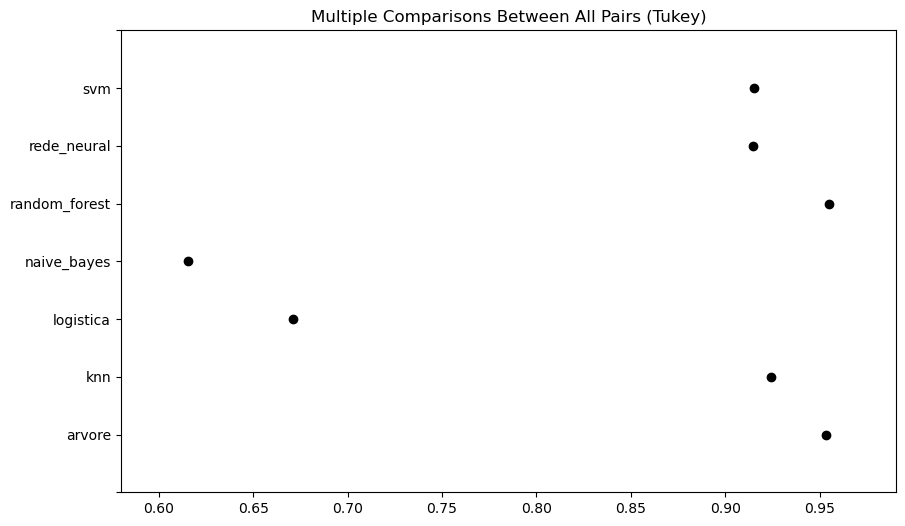

In [106]:
fig = teste_estatistico.plot_simultaneous()
fig.show();

Tendo em vista que, o teste de Tukey não apontou uma diferença clara entre a Árvore de decisão e a Random Forest, o modelo foi selecionado a partir das seguintes premissas:
 Métrica de avaliação | Árvore de decisão | Random Forest 
:----------|-------------|----------
**R²**| 93,42% | 93,85% 
**Acurácia**| 95,32% | 95,49% 
**Teste de Tukey**| Não há diferença significativa | Não há diferença significativa 
**Tempo de treinamento e recursos computacionais**|Mais rápido, toma menos recursos|Mais demorado, complexo

Como o foco é encontrar uma solução prática para incorporar as particularidades de diferentes estilos de vida ao cálculo do IMC, entendo que um modelo mais rápido seja o ideal, inclusive pelo fato de que não houve diferença significativa entre as médias dos modelos, assim como pela proximidade entre o desempenho dos modelos nas demais métricas. Portanto, o modelo escolhido foi a Árvore de decisão. 

## Armazenamento do modelo escolhido

In [108]:
arvore = DecisionTreeClassifier(criterion=melhores_parametros_tree['criterion'], min_samples_leaf=melhores_parametros_tree['min_samples_leaf'], min_samples_split=melhores_parametros_tree['min_samples_split'], splitter=melhores_parametros_tree['splitter'], random_state=0)
arvore.fit(X, y)
pickle.dump(arvore, open('classificador_imc.sav', 'wb'))

## Utilização do modelo treinado

In [109]:
arvore_decisao = pickle.load(open('classificador_imc.sav', 'rb'))

In [123]:
importancia_atributo = arvore_decisao.feature_importances_
importancia_atributo

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.11948629, 0.02033143, 0.19154162, 0.63081686, 0.00227075,
       0.01106042, 0.        , 0.00408629, 0.00426545, 0.        ,
       0.01021305, 0.        , 0.00426572, 0.00166213, 0.        ])

In [131]:
feature_names = ['Automobile', 'Bike', 'Motorbike', 'Public_Transportation', 'Walking', 'Female', 'Age', 'Height', 
                 'Weight', 'obesity_history', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'smoker', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC']
df_previsores = pd.DataFrame(importancia_atributo, index=feature_names)
df_previsores.sort_values(by=0, ascending=False, inplace=True)

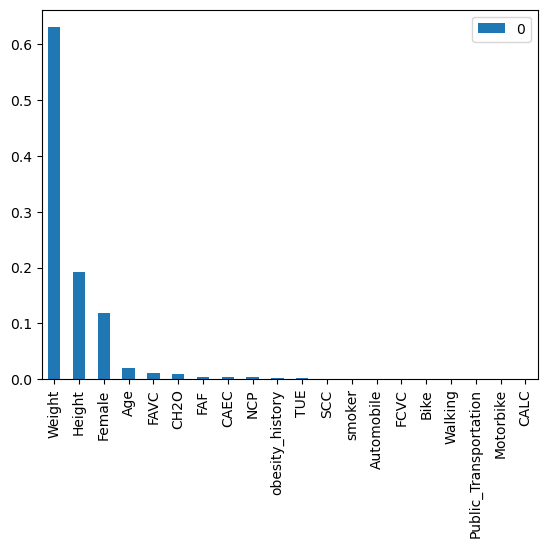

In [132]:
# importância dos atributos da árvore de decisão, em ordem decrescente
df_previsores.plot(kind='bar');

In [144]:
previsoes = arvore_decisao.predict(X_teste)
accuracy_score(y_teste, previsoes)

0.9905362776025236

0.9905362776025236

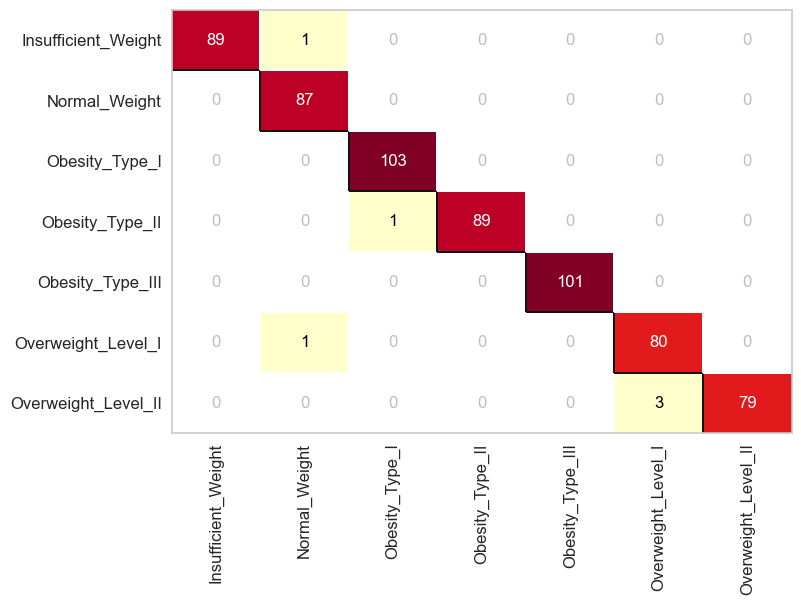

In [146]:
cm = ConfusionMatrix(arvore_decisao)
cm.fit(X_treino, y_treino)
cm.score(X_teste, y_teste)

**Acurácia (Accuracy):** É a proporção de exemplos classificados corretamente pelo modelo em relação ao total de exemplos. É uma métrica geralmente utilizada para avaliar o desempenho global do modelo.

**Precisão (Precision):** É a proporção de exemplos positivos previstos corretamente pelo modelo em relação a todos os exemplos positivos previstos pelo modelo. Essa métrica indica a capacidade do modelo de não classificar erroneamente exemplos negativos como positivos.

**Recall (Sensibilidade ou Revocação):** É a proporção de exemplos positivos previstos corretamente pelo modelo em relação a todos os exemplos positivos reais. Essa métrica indica a capacidade do modelo de encontrar todos os exemplos positivos.

**F1-score (F1-Score):** É a média harmônica entre precisão e recall. Essa métrica fornece um equilíbrio entre precisão e recall, sendo útil quando há um desequilíbrio entre as classes.

**Support:** em problemas de classificação é o número de ocorrências de cada classe no conjunto de dados.

Segundo a tabela a seguir, o modelo classifica corretamente, em média, 99,05% dos casos (acurácia).
Quanto à precisão do modelo:
- Insufficient_Weight =	Quando o modelo prevê essa classe, está correto em 100% dos casos.
- Normal_Weight = Quando o modelo prevê essa classe, está correto em 97,75% dos casos.
- Obesity_Type_I = Quando o modelo prevê essa classe, está correto em 99,03% dos casos.
- Obesity_Type_II = Quando o modelo prevê essa classe, está correto em 100% dos casos.
- Obesity_Type_III = Quando o modelo prevê essa classe, está correto em 100% dos casos.
- Overweight_Level_I = Quando o modelo prevê essa classe, está correto em 96,38% dos casos.
- Overweight_Level_II = Quando o modelo prevê essa classe, está correto em 100% dos casos. 

In [152]:
rep = pd.DataFrame(classification_report(y_teste, previsoes, target_names=arvore_decisao.classes_, output_dict=True)).transpose()
rep

,precision,recall,f1-score,support
Insufficient_Weight,1.000000,0.988889,0.994413,90.000000
Normal_Weight,0.977528,1.000000,0.988636,87.000000
Obesity_Type_I,0.990385,1.000000,0.995169,103.000000
Obesity_Type_II,1.000000,0.988889,0.994413,90.000000
Obesity_Type_III,1.000000,1.000000,1.000000,101.000000
Overweight_Level_I,0.963855,0.987654,0.975610,81.000000
Overweight_Level_II,1.000000,0.963415,0.981366,82.000000
accuracy,0.990536,0.990536,0.990536,0.990536
macro avg,0.990253,0.989835,0.989944,634.000000
weighted avg,0.990736,0.990536,0.990544,634.000000
